In [37]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [52]:
ds = pd.read_csv("A_tas_lat.41_lon.272_spatial.2_reduce.max.csv", parse_dates = ["time"])
ds

/tmp/ipykernel_685/1962783369.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ds = pd.read_csv("A_tas_lat.41_lon.272_spatial.2_reduce.max.csv", parse_dates = ["time"])


,time,tas
0,0011-01-01 00:00:00,275.69670
1,0011-01-02 00:00:00,273.68964
2,0011-01-03 00:00:00,271.51093
3,0011-01-04 00:00:00,267.61884
4,0011-01-05 00:00:00,268.49182
...,...,...
763352,2100-12-27 00:00:00,272.17240
763353,2100-12-28 00:00:00,274.71240
763354,2100-12-29 00:00:00,276.67300
763355,2100-12-30 00:00:00,271.88593


In [55]:
# Extract the data and add a "year" column
ds.set_index(ds.columns[0], inplace=True)
ds["year"] = [ds.index[i].split("-")[0] for i in range(ds.shape[0])]

In [56]:
## Get the maximum every year
obs = ds.groupby(["year"]).max()


In [59]:
## Define the gumbel (logged) pdf and cdf 
def pdf_gumbel(obs, parameters):
    mu, beta  = parameters
    z = (obs - mu)/beta
    
    obs_p = np.log(1/beta * np.exp(-(z + np.exp(-z))))
    return obs_p

def cdf_gumbel(obs, parameters):
    mu, beta  = parameters
    z = (obs - mu)/beta
    
    obs_p = np.exp(-np.exp(-z))
    return obs_p



In [60]:
## Define the weibull (logged) pdf and cdf 
def pdf_weibull(obs, parameters):
    lamb, k  = parameters
    obs_p = np.log((k/lamb)*np.power((obs/lamb), k-1)*np.exp(-1*np.power(obs/lamb, k)))
    return obs_p
    
def cdf_weibull(obs, parameters):
    lamb, k  = parameters
    obs_p = 1 - np.exp(-np.power(obs/lamb, k))
    return obs_p



In [61]:
## Define the grid (parameter combinations) that will be used to calculate the likelihood
mu_vals = np.linspace(314, 322, 100)
beta_vals = np.linspace(30, 225, 100)

mu_grids, beta_grids = np.meshgrid(mu_vals, beta_vals)
mu_grids = mu_grids.flatten()
beta_grids = beta_grids.flatten()

para_grid = np.column_stack((mu_grids, beta_grids))


In [62]:
## Calculate the likelihood
log_prob_grid = np.array([pdf_weibull(obs,para_grid[row]).sum() for row in range(para_grid.shape[0])])


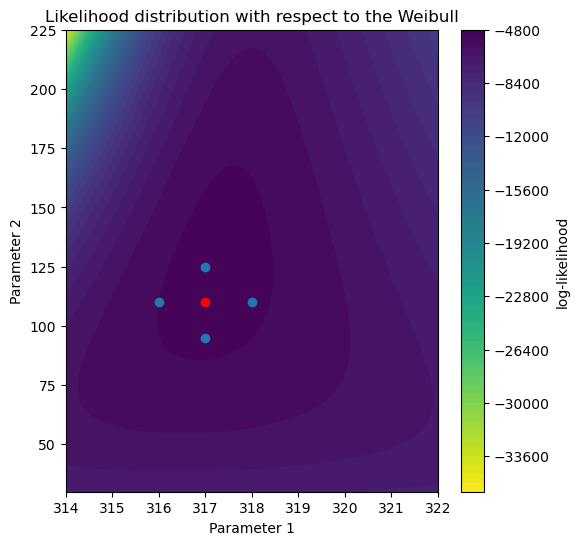

In [63]:
## Some visualization
plt.figure(figsize=(6, 6))
contour = plt.contourf(mu_grids.reshape((100,100)), beta_grids.reshape((100,100)), 
                       log_prob_grid.reshape((100,100)), cmap='viridis_r', levels = 50)
plt.colorbar(contour, label='log-likelihood')
plt.title('Likelihood distribution with respect to the Weibull')
plt.scatter(317, 110, color = "red")
plt.scatter([317, 317, 316, 318], [95, 125, 110, 110])
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.show()


In [29]:
## Select four different combinations of the parameters (see figure above), 
## and determine the max and min of the cumulative distribution.
seris1 = cdf_weibull(np.linspace(305, 330, 100), [317, 95])
seris2 = cdf_weibull(np.linspace(305, 330, 100), [317, 125])
seris3 = cdf_weibull(np.linspace(305, 330, 100), [316, 110])
seris4 = cdf_weibull(np.linspace(305, 330, 100), [318, 110])

max_series = np.maximum.reduce([seris1, seris2, seris3, seris4])
min_series = np.minimum.reduce([seris1, seris2, seris3, seris4])

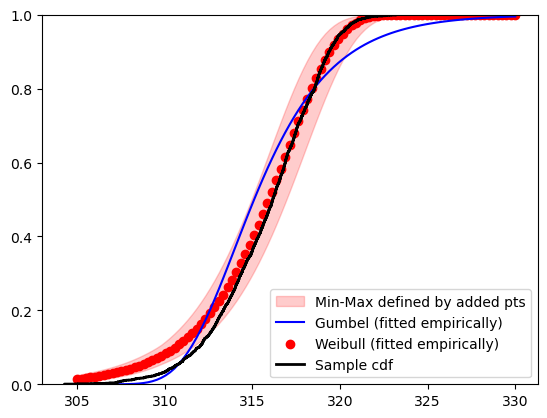

In [64]:
## Visualization

fig, ax = plt.subplots()

ax.fill_between(np.linspace(305, 330, 100), min_series, max_series, color='red', alpha=0.2, label='Min-Max defined by added pts')
ax.plot(np.linspace(305, 330, 100),cdf_gumbel(np.linspace(305, 330, 100), [314, 3]), 
            color = "blue", label = "Gumbel (fitted empirically)")
ax.scatter(np.linspace(305, 330, 100),cdf_weibull(np.linspace(305, 330, 100), [317, 110]), 
            color = "red", label = "Weibull (fitted empirically)")
ax.ecdf(obs.tas.values, color = "black", label = "Sample cdf", linewidth = 2)

ax.legend(loc = "lower right")